In [1]:
import os, random, gc, math, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import tensorflow as tf
import keras_preprocessing.image
import tensorflow.keras.backend as k
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import metrics
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.utils import class_weight
from PIL import Image

/home/chatbot/python/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/chatbot/python/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/chatbot/python/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/chatbot/python/lib64/python3.6/site-packages/tensorflow/python/framework/dty

In [3]:
%matplotlib inline
is_pretrained = True # Trained with locked base_model
keep_training = False # Additional unlocked layers
batch_size = 39
width = 640
height = 480
learning_rate = 1e-2
proj_dir = './data'

# Google Drive
#drive.mount('/content/gdrive')

print('Tensorflow version: {}'.format(tf.__version__))

Tensorflow version: 1.14.0


In [4]:
xray_path = '{}/ChestXRay2017.zip'.format(proj_dir).replace(' ', '\\ ')
!unzip $xray_path

Archive:  ./data/ChestXRay2017.zip
   creating: chest_xray/
  inflating: chest_xray/.DS_Store    
   creating: __MACOSX/
   creating: __MACOSX/chest_xray/
  inflating: __MACOSX/chest_xray/._.DS_Store  
   creating: chest_xray/test/
  inflating: chest_xray/test/.DS_Store  
   creating: __MACOSX/chest_xray/test/
  inflating: __MACOSX/chest_xray/test/._.DS_Store  
   creating: chest_xray/test/PNEUMONIA/
  inflating: chest_xray/test/PNEUMONIA/person147_bacteria_706.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person100_bacteria_482.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person78_bacteria_382.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person124_bacteria_589.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person1647_virus_2848.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person1675_virus_2891.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person89_bacteria_440.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person35_virus_80.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person122_bact

In [5]:
def dir_file_count(directory):
  total_files = 0
  for root, dirs, files in os.walk(".", topdown=False):
    total_files += len(list(filter(lambda x: x.endswith('.jpeg'), files)))
  return total_files

def xray_process(im):
  # X-Rays are negative images. Imagenet was trained on normal images.
  im = 255. - im

  # Imagenet tensorflow samples are scaled between -1 (black) and 1 (white)
  # https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py
  im /= 255.
  im -= .5
  im *= 2.
  return im

target_size = (height, width)
class_mode = 'categorical'
training_dir = './chest_xray/train'
testing_dir = './chest_xray/test'

train_datagen = ImageDataGenerator(rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   preprocessing_function=xray_process)

train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=target_size,
    interpolation='bicubic',
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle=True)

Found 5232 images belonging to 2 classes.


In [6]:
test_datagen = ImageDataGenerator(rotation_range=10,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest',
                                  preprocessing_function=xray_process)

test_generator = test_datagen.flow_from_directory(
    testing_dir,
    target_size=target_size,
    interpolation='bicubic',
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle=False)

Found 624 images belonging to 2 classes.


In [7]:
def get_weight(y):
    class_weight_current = class_weight.compute_class_weight('balanced',
                                                             np.unique(y), y)
    return class_weight_current

class_w = get_weight(train_generator.classes)
print(class_w)

[1.93921423 0.6737059 ]


In [8]:
def get_image_set(image_set, image_type):
  def get_image_path(path_pre, image_name):
    return '{}/{}/{}/{}'.format(path_pre, image_set, image_type, image_name)

  path_pre = './chest_xray'
  image_list = os.listdir('{}/{}/{}'.format(path_pre, image_set, image_type))
  image_list = list(map(lambda x: get_image_path(path_pre, x), image_list))

  # Ignore .DS_Store files
  image_list = list(filter(lambda x: x.endswith('.jpeg'), image_list))
  return image_list

tr_normal = get_image_set('train', 'NORMAL')
tr_pneumonia = get_image_set('train', 'PNEUMONIA')

te_normal = get_image_set('test', 'NORMAL')
te_pneumonia = get_image_set('test', 'PNEUMONIA')

images_normal = tr_normal + te_normal
images_pneumonia = tr_pneumonia + te_pneumonia
images_pneumonia_bacterial = [img for img in images_pneumonia
                              if img.split('/')[-1].split('_')[1] == 'bacteria']
images_pneumonia_viral = [img for img in images_pneumonia
                          if img.split('/')[-1].split('_')[1] == 'virus']

images_full = images_normal + images_pneumonia
images_test = te_normal + te_pneumonia

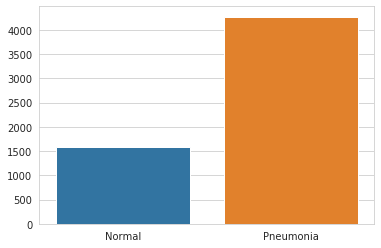

In [9]:
sns.set_style('whitegrid')
sns.barplot(x=['Normal', 'Pneumonia'],
            y=[len(images_normal),
               len(images_pneumonia)])

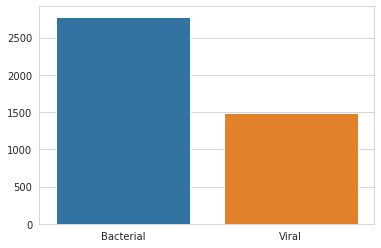

In [10]:
sns.set_style('whitegrid')
sns.barplot(x=['Bacterial', 'Viral'],
            y=[len(images_pneumonia_bacterial),
               len(images_pneumonia_viral)])

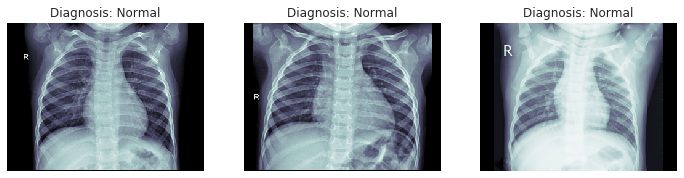

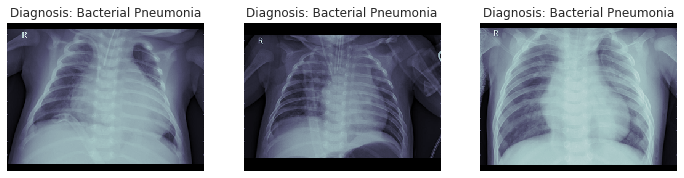

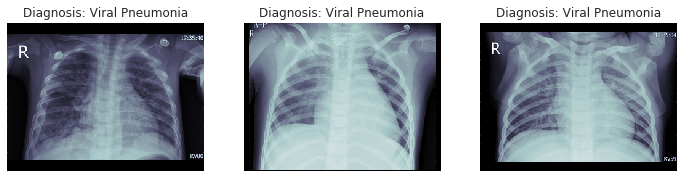

In [11]:
def get_image(path):
  return cv2.imread(path, 0)

def get_resized_image(path, width, height):
  im = Image.fromarray(get_image(path))
  im_w, im_h = im.size

  # Proportionally scale to be contained within canvas bounds.
  if im_w > width:
    im_h = int(width/im_w * im_h)
    im_w = width
  if im_h > height:
    im_w = int(height/im_h * im_w)
    im_h = height

  if [im_w, im_h] != list(im.size):
    im.thumbnail((im_w, im_h), Image.ANTIALIAS)

  # Return the image over a black background.    
  im_resized = Image.new('RGB', (width, height), (0, 0, 0))
  offset = ((width - im.size[0]) // 2,
            (height - im.size[1]) // 2)
  im_resized.paste(im, offset)

  return np.array(im_resized)

def plot_sample_xrays(image_set, image_label,
                      width=width//2, height=height//2,
                      rows=1, cols=3,
                      size_w=4, size_h=3):
  f,ax = plt.subplots(rows, cols, figsize=(cols*size_w, rows*size_h))

  for idx in range(rows*cols):
    i = random.randint(0, len(image_set))
    im = get_resized_image(image_set[i], width, height)[:, :, 0]
    ax[idx%cols].imshow(im, cmap='bone')
    ax[idx%cols].axis('off')
    ax[idx%cols].set_title('Diagnosis: {}'.format(image_label))
  plt.show()

plot_sample_xrays(images_normal, 'Normal')
plot_sample_xrays(images_pneumonia_bacterial, 'Bacterial Pneumonia')
plot_sample_xrays(images_pneumonia_viral, 'Viral Pneumonia')

In [34]:
def build_model(optimizer):
  base_model = InceptionV3(weights='imagenet', include_top=False,
                           input_shape=(height, width, 3)) # 311 Layers
  x = base_model.output
  x = Dropout(0.4)(x)
  x = GlobalAveragePooling2D()(x)
  x = BatchNormalization()(x)
  x = Dropout(0.4)(x)
  x = Dense(16)(x)
  x = LeakyReLU()(x)
  x = Dropout(0.4)(x)
  p = Dense(len(class_w), activation='softmax')(x)
  model = Model(inputs=base_model.input, outputs=p)

  for layer in base_model.layers:
    layer.trainable = False

  model.compile(optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy'])

  return model

In [35]:
model = build_model(SGD(learning_rate=learning_rate, momentum=0.9))
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 480, 640, 3) 0                                            
__________________________________________________________________________________________________
conv2d_282 (Conv2D)             (None, 239, 319, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_285 (BatchN (None, 239, 319, 32) 96          conv2d_282[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, 239, 319, 32) 0           batch_normalization_285[0][0]    
____________________________________________________________________________________________

In [43]:
# Creates directory, if directory exists removes if remove parameter is True
def create_directory(directory_path, remove=True):
  if remove and os.path.exists(directory_path):
    try:
      print(directory_path)
      shutil.rmtree(directory_path)
      os.mkdir(directory_path)
    except:
      print("Could not remove directory : ", directory_path)
      return False
  else:
    try:
      print(directory_path)
      os.mkdir(directory_path)
    except:
      print("Could not create directory: ", directory_path)
      return False   
  return True

main_model_dir = '{}/models'.format(proj_dir)
m_dir = main_model_dir + '/' + time.strftime('%Y-%m-%d_%H-%M-%S') + '/'
ckp_path = m_dir + 'v_acc-{val_acc:.2f}-v_loss-{val_loss:.2f}.hdf5'
create_directory(m_dir, remove=True)

checkpoint = ModelCheckpoint(ckp_path,
                             monitor='val_acc', 
                             save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              patience=2,
                              cooldown=2,
                              min_lr=1e-10,
                              verbose=1)
early_stopping = EarlyStopping(monitor='val_acc',
                               mode='max',
                               patience=3,
                               verbose=1,
                               restore_best_weights=True)
callbacks = [checkpoint, reduce_lr, early_stopping]

model.save_weights('v_acc-0.76-v_loss-0.51.hdf5')

./data/models/2019-10-01_09-33-59/


In [46]:
def unlock_layers(num_layers):
  for l in range(311 - num_layers, 311):
      model.layers[l].trainable = True

def train_model():
  hist = model.fit_generator(train_generator,
                             steps_per_epoch=len(train_generator),
                             epochs=10,
                             verbose=1,
                             callbacks=callbacks,
                             validation_data=test_generator,
                             validation_steps=len(test_generator),
                             class_weight=class_w)

  plt.plot(hist.history['acc'])
  plt.plot(hist.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validate'], loc='best')
  plt.show()

if keep_training:
  # After Transfer Learning, let's open up a few layers for continued education.
  unlock_layers(11)
  model.compile(SGD(learning_rate=1e-9, momentum=0.9),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  model.summary()

if is_pretrained:
   #print ('{}/v_acc-0.76-v_loss-0.51.hdf5'.format(main_model_dir));
   #print ('{}/models'.format(proj_dir));
  model.load_weights('{}/v_acc-0.76-v_loss-0.51.hdf5'.format(main_model_dir))

# train_model()

In [47]:
vl_score = model.predict_generator(test_generator)

classes = ['Normal', 'Pneumonia']
print(classification_report(test_generator.classes,
                            np.argmax(vl_score, axis=1),
                            target_names=classes))
print('AUC: ', roc_auc_score(test_generator.classes,
                             np.argmax(vl_score, axis=1)))

              precision    recall  f1-score   support

      Normal       0.38      0.29      0.33       234
   Pneumonia       0.63      0.71      0.67       390

    accuracy                           0.55       624
   macro avg       0.50      0.50      0.50       624
weighted avg       0.53      0.55      0.54       624

AUC:  0.5025641025641026


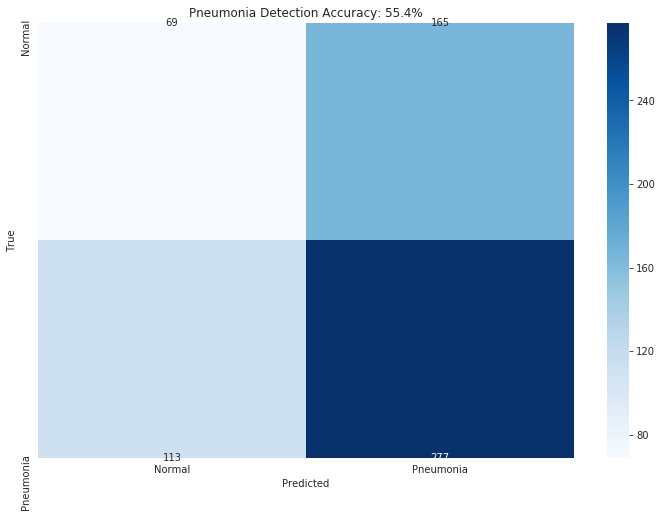

In [48]:
acc = accuracy_score(test_generator.classes, np.argmax(vl_score, axis=1))*100.0
cm = confusion_matrix(test_generator.classes, np.argmax(vl_score, axis=1))
cm_df = pd.DataFrame(cm, index=classes, columns=classes)

plt.figure(figsize=(12,8))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Pneumonia Detection Accuracy: {0:.1f}%'.format(acc))
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

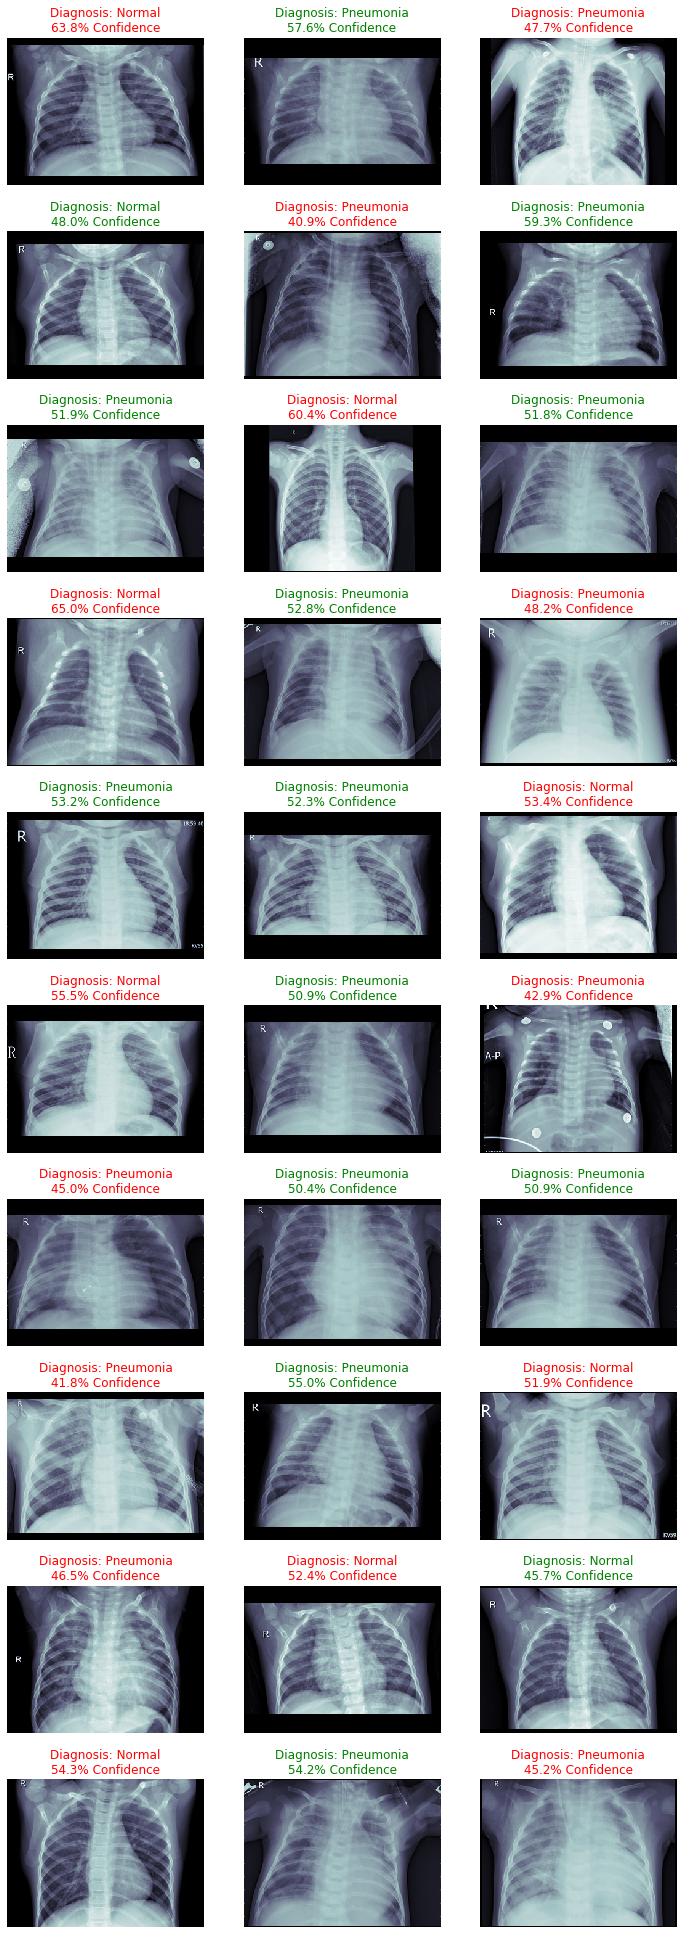

In [49]:
def plot_val_xrays(width=width//2, height=height//2,
                   rows=10, cols=3,
                   size_w=4, size_h=3.5):
  f,ax = plt.subplots(rows, cols, figsize=(cols*size_w, rows*size_h))

  label_CM = {
    0: 'red',  # Incorrect diagnosis
    1: 'green' # Correct diagnosis
  }

  for idx in range(0, rows*cols):
    i = random.randint(0, len(images_test))
    pred = np.round(vl_score[i][1])
    score = 1 if test_generator.classes[i] == pred else 0
        
    diagnosis_type = 'Pneumonia' if test_generator.classes[i] == 1 else 'Normal'
    diagnosis_conf = vl_score[i][1] * 100.0
    diagnosis = 'Diagnosis: {}\n{:.1f}% Confidence'.format(diagnosis_type,
                                                           diagnosis_conf)

    im = get_resized_image(images_test[i], width, height)[:, :, 0]
    ax[idx//cols,idx%cols].imshow(im, cmap='bone')
    ax[idx//cols,idx%cols].axis('off')
    ax[idx//cols,idx%cols].set_title(diagnosis, color=label_CM[score])
  plt.show()

plot_val_xrays()
